<a href="https://colab.research.google.com/github/zar55/COSC_640_Intro_to_AI/blob/main/Lab_05_zziauddin1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COSC-640: Lab 5

**Zargham Ziauddin**

[PLACEHOLDER_FOR_NOTEBOOK_LINK]


## Getting Started

Follow the instructions below to copy this notebook and to perform some initial setup.

1. Copy this notebook by selecting `File > Save a copy in Drive`.
2. A new window should open for the copied notebook. Move the new notebook to your course folder in Google Drive by selecting `File > Move` and then selecting the desired folder.
3. Update the name of the notebook by removing "Copy of" and replacing "Username" with your actual username.
4. Update the first cell in the notebook by specifying your course number (440 or 640) and by replacing "**Student Name**" with your actual name.
5. Do not edit the line that says `PLACEHOLDER_FOR_NOTEBOOK_LINK`. This will be used by the [Notebook Renderer](https://colab.research.google.com/drive/1CJTipys46ldZxJFwnt7XbdjQUfkmoXeU?usp=sharing) tool to insert a link to your Colab notebook.
6. Enable link sharing for your notebook.

## Preparing the Colab Environment

Run the cell below to download and extract the datasets required for this lab. All of the required datasets will then be stored on the Colab VM in a folder named `data/`.

In [ ]:
%%capture
!wget -nc https://github.com/drbeane/datasets/raw/main/COSC_640_data.zip
!unzip -n COSC_640_data.zip -d data/

Run the cell below to import the necessary tools for this assignment. No other import statements are required for this lab, and no other import statements should be included in this assignment.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

np.set_printoptions(linewidth=150)

# Part 1: Breast Cancer Data

In Part 1, you will be working with oncological data to build a model that classifies breast cancer tumors as "malignant" or "benign". You can find more information about the dataset, including a description of the features here: [Kaggle: Wisconsin Breast Cancer Data Set](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

## 1.A - Load the Data

Load the data from the file `data/breast_cancer.csv` into a DataFrame. Use the `sample()` method to shuffle the data, setting `random_state=1`. Display the head of the DataFrame.

In [ ]:
breast_cancer = pd.read_csv('data/breast_cancer.csv')
breast_cancer.sample(frac=1, random_state=1).head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
421,906564,B,14.69,13.98,98.22,656.1,0.10310,0.18360,0.14500,0.06300,...,16.46,18.34,114.10,809.2,0.1312,0.36350,0.3219,0.11080,0.2827,0.09208
47,85715,M,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,...,15.67,27.95,102.80,759.4,0.1786,0.41660,0.5006,0.20880,0.3900,0.11790
292,891670,B,12.95,16.02,83.14,513.7,0.10050,0.07943,0.06155,0.03370,...,13.74,19.93,88.81,585.4,0.1483,0.20680,0.2241,0.10560,0.3380,0.09584
186,874217,M,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,...,21.31,26.36,139.20,1410.0,0.1234,0.24450,0.3538,0.15710,0.3206,0.06938
414,905680,M,15.13,29.81,96.71,719.5,0.08320,0.04605,0.04686,0.02739,...,17.26,36.91,110.10,931.4,0.1148,0.09866,0.1547,0.06575,0.3233,0.06165



## 1.B - Label Distribution

Use the `value_counts()` method to display the distribution of the label values as proportions. Note that labels are stored in the `diagnosis` column.

In [ ]:
breast_cancer.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

## 1.C - Feature and Label Arrays

Create a feature array containing all columns of your DataFrame except for `id` and `diagnosis`. Then create a label array. Display the shape of both arrays.

In [ ]:
bc_feature = breast_cancer.drop(columns=['id', 'diagnosis'])
bc_label = breast_cancer.diagnosis.values

print(bc_feature.shape)
print(bc_label.shape)

(569, 30)
(569,)


## 1.D - Feature Scaling

Create an instance of StandardScaler and use it to create a scaled feature array.

In [ ]:
bc_standard = StandardScaler()
bc_feature_scaled = bc_standard.fit_transform(bc_feature)
print(bc_feature_scaled)

[[ 1.09706398 -2.07333501  1.26993369 ...  2.29607613  2.75062224  1.93701461]
 [ 1.82982061 -0.35363241  1.68595471 ...  1.0870843  -0.24388967  0.28118999]
 [ 1.57988811  0.45618695  1.56650313 ...  1.95500035  1.152255    0.20139121]
 ...
 [ 0.70228425  2.0455738   0.67267578 ...  0.41406869 -1.10454895 -0.31840916]
 [ 1.83834103  2.33645719  1.98252415 ...  2.28998549  1.91908301  2.21963528]
 [-1.80840125  1.22179204 -1.81438851 ... -1.74506282 -0.04813821 -0.75120669]]


## 1.E - Cross Validation for Logistic Regression

Create an instance of `LogisticRegression`. Use `cross_value_score()` to estimate the model's out-of-sample performance on the dataset. Use 10-fold CV with "accuracy" as the metric. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

In [ ]:
bc_lr = LogisticRegression()

bc_score = cross_val_score(bc_lr, bc_feature_scaled, bc_label, scoring='accuracy', cv=10, n_jobs=-1)

print(f"Scores: {bc_score.round(3)}")
print(f"Mean Score: {bc_score.mean().round(3)}")

Scores: [0.982 0.982 0.982 0.965 0.982 0.982 0.947 1.    1.    0.982]
Mean Score: 0.981


## 1.F - Cross Validation for KNN

Create an instance of `KNeighborsClassifier`, selecting a value of your choice for `n_neighbors`. Use `cross_value_score()` to estimate the model's out-of-sample performance on the dataset. Use 10-fold CV with accuracy as the metric. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

Experiment with the value of `n_neighbors` until you find a model with a CV score of **at least 0.97**.

In [ ]:
bc_neighbor = KNeighborsClassifier(n_neighbors=5)

bc_score = cross_val_score(bc_neighbor, bc_feature_scaled, bc_label, scoring='accuracy', cv=10, n_jobs=-1)

print(f"Scores: {bc_score.round(3)}")
print(f"Mean Score: {bc_score.mean().round(3)}")

Scores: [0.982 0.965 0.93  0.982 1.    0.965 0.947 0.965 0.947 0.982]
Mean Score: 0.967


## 1.G - Classification Report

Identify which of the two models gave you the best results. Then use that model with `cross_val_predict()` with `cv=10` to generate out-of-sample predictions for the dataset. Use these predictions with `classification_report()` to generate a classification report.


In [ ]:
bc_predict = cross_val_predict(bc_lr, bc_feature_scaled, bc_label, cv=10) #, n_jobs=-1

bc_class = classification_report(bc_label,bc_predict)

print(bc_class)

              precision    recall  f1-score   support

           B       0.98      0.99      0.98       357
           M       0.99      0.96      0.97       212

    accuracy                           0.98       569
   macro avg       0.98      0.98      0.98       569
weighted avg       0.98      0.98      0.98       569



## 1.H - Confusion Matrix

Use your out-of-sample predictions with `confusion_matrix()` to generate a confusion matrix. Display the confusion matrix as a DataFrame, with the rows and columns labeled according to the actual class names.

In [ ]:
bc_confusion = confusion_matrix(bc_label,bc_predict)

diagnosis = np.unique(bc_label)

bc_confusion_df = pd.DataFrame(bc_confusion, index=diagnosis, columns=diagnosis)

bc_confusion_df

,B,M
B,354,3
M,8,204


## 1.I - Applying the Model

A lists containing feature values for two new observations have been provided for you. Scale these using the scaler you created earlier. Then fit your best-performing model to the training data and use the predict_proba() method to generate probability predictions for the new observations. Print the resulting probability array.

In [ ]:
x1 = [16.5, 18.29, 106.6, 838.1, 0.0969, 0.0847, 0.0586, 0.0483, 0.1495, 0.0559,
      0.3389, 1.439, 2.344, 33.58, 0.0073, 0.018, 0.0183, 0.0103, 0.0169, 0.002,
      18.13, 25.45, 117.2, 1009.0, 0.1338, 0.1679, 0.1663, 0.0912, 0.2394, 0.0647]

x2 = [16.03, 15.51, 105.8, 793.2, 0.0949, 0.1371, 0.1204, 0.0704, 0.1782, 0.0598,
      0.3371, 0.7476, 2.629, 33.27, 0.0058, 0.0324, 0.0372, 0.0146, 0.0147, 0.0031,
      18.76, 21.98, 124.3, 1070.0, 0.1435, 0.4478, 0.4956, 0.1981, 0.3019, 0.0912]

X_new = [x1, x2]

In [ ]:
# Add your code here.
bc_lr.fit(bc_feature_scaled, bc_label)

bc_new_feature_scaled = bc_standard.transform(X_new)


bc_pred = bc_lr.predict(bc_new_feature_scaled)
print(bc_pred,'\n')

bc_prob = bc_lr.predict_proba(bc_new_feature_scaled)
print(bc_prob.round(3))

['B' 'M'] 

[[0.577 0.423]
 [0.024 0.976]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Part 2: Diamond Data

In Part 2, you will be working with dataset containing information about nearly 54,000 diamonds. Your goal will be to build a model to try to predict the cut quality of the diamonds based on several numerical inputs. You can find more information about the dataset, including a description of the features here: [Tensorflow: Diamonds Dataset](https://www.tensorflow.org/datasets/catalog/diamonds)

## 2.A - Load the Data

Load the data from the file `data/diamonds.csv` into a DataFrame. Use the `sample()` method to shuffle the data, setting `random_state=1`. Display the head of the DataFrame.

In [ ]:
diamonds = pd.read_csv('data/diamonds.csv')
diamonds.sample(frac=1, random_state=1).head()

,carat,cut,color,clarity,depth,table,price,x,y,z
2714,0.33,Ideal,H,SI1,61.7,55.0,564,4.43,4.46,2.74
14653,1.20,Ideal,I,VS2,62.1,57.0,5914,6.78,6.71,4.19
52760,0.62,Ideal,D,VS1,61.0,57.0,2562,5.51,5.54,3.37
48658,0.34,Good,H,VS2,63.1,56.0,537,4.41,4.46,2.80
14812,1.20,Ideal,E,SI2,62.5,55.0,5964,6.77,6.84,4.25


## 2.B - Label Distribution
Use the `value_counts()` method to display the distribution of the label values as proportions. Note that labels are stored in the `cut` column.

In [ ]:
diamonds.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

## 2.C - Feature and Label Arrays

Create a feature array containing all numerical columns of your DataFrame. Then create a label array. Display the shape of both arrays.

In [ ]:
diamonds_feature = diamonds.drop(columns=['cut', 'color', 'clarity'])
diamonds_label = diamonds.cut.values

print(diamonds_feature.shape)
print(diamonds_label.shape)

(53940, 7)
(53940,)


## 2.D - Feature Scaling

Create an instance of StandardScaler and use it to create a scaled feature array.

In [ ]:
diamonds_standard = StandardScaler()

diamonds_feature_scaled = diamonds_standard.fit_transform(diamonds_feature)

print(diamonds_feature_scaled)

[[-1.19816781 -0.17409151 -1.09967199 ... -1.58783745 -1.53619556 -1.57112919]
 [-1.24036129 -1.36073849  1.58552871 ... -1.64132529 -1.65877419 -1.74117497]
 [-1.19816781 -3.38501862  3.37566251 ... -1.49869105 -1.45739502 -1.74117497]
 ...
 [-0.20662095  0.73334442  1.13799526 ... -0.06343409 -0.04774083  0.03013526]
 [ 0.13092691 -0.52310533  0.24292836 ...  0.37338325  0.33750627  0.28520393]
 [-0.10113725  0.31452784 -1.09967199 ...  0.08811478  0.11861587  0.14349912]]


## 2.E - Cross Validation for Logistic Regression

Create an instance of `LogisticRegression`. Use `cross_value_score()` to estimate the model's out-of-sample performance on the dataset. Use 10-fold CV with "accuracy" as the metric. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

In [ ]:
diamonds_lr = LogisticRegression()

diamonds_score = cross_val_score(diamonds_lr, diamonds_feature_scaled, diamonds_label, scoring='accuracy', cv=10, n_jobs=-1)

print(f"Scores: {diamonds_score.round(3)}")
print(f"Mean Score: {diamonds_score.mean().round(3)}")

Scores: [0.674 0.645 0.64  0.623 0.653 0.602 0.627 0.667 0.655 0.661]
Mean Score: 0.645


## 2.F - Cross Validation for KNN

Create an instance of `KNeighborsClassifier`, selecting a value of your choice for `n_neighbors`. Use `cross_value_score()` to estimate the model's out-of-sample performance on the dataset. Use 10-fold CV with accuracy as the metric. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

Experiment with the value of `n_neighbors` until you find a model with a CV score of **at least 0.72**.

In [ ]:
diamonds_neighbor = KNeighborsClassifier(n_neighbors=95)

diamonds_score = cross_val_score(diamonds_neighbor, diamonds_feature_scaled, diamonds_label, scoring='accuracy', cv=10, n_jobs=-1)

print(f"Scores: {diamonds_score.round(3)}")
print(f"Mean Score: {diamonds_score.mean().round(3)}")

Scores: [0.714 0.681 0.615 0.461 0.526 0.553 0.725 0.704 0.699 0.691]
Mean Score: 0.637


## 2.G - Classification Report

Identify which of the two models gave you the best results. Then use that model with `cross_val_predict()` with `cv=10` to generate out-of-sample predictions for the dataset. Use these predictions with `classification_report()` to generate a classification report.


In [ ]:
diamonds_predict = cross_val_predict(diamonds_lr, diamonds_feature_scaled, diamonds_label, cv=10, n_jobs=-1) #

diamonds_class = classification_report(diamonds_label,diamonds_predict)

print(diamonds_class)

              precision    recall  f1-score   support

        Fair       0.78      0.49      0.60      1610
        Good       0.59      0.12      0.20      4906
       Ideal       0.70      0.86      0.77     21551
     Premium       0.65      0.69      0.67     13791
   Very Good       0.49      0.44      0.46     12082

    accuracy                           0.64     53940
   macro avg       0.64      0.52      0.54     53940
weighted avg       0.63      0.64      0.62     53940



## 2.H - Confusion Matrix

Use your out-of-sample predictions with `confusion_matrix()` to generate a confusion matrix. Display the confusion matrix as a DataFrame, with the rows and columns labeled according to the actual class names.

In [ ]:
diamonds_confusion = confusion_matrix(diamonds_label,diamonds_predict)

cuts = np.unique(diamonds_label)

diamonds_confusion_df = pd.DataFrame(diamonds_confusion, index=cuts, columns=cuts)

diamonds_confusion_df

,Fair,Good,Ideal,Premium,Very Good
Fair,791,141,179,386,113
Good,187,607,1249,1263,1600
Ideal,6,6,18535,1512,1492
Premium,4,20,1866,9567,2334
Very Good,28,255,4531,1999,5269


# Part 3: Mobile Device Price Data

In Part 3, you will be working with a synthetic dataset containing information about several mobile devices. Your goal is to build a model to predict which of four price groups a mobile device falls into based on its characteristics. You can find more information about the dataset, including a description of the features here: [Kaggle: Mobile Price Classification](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification)

## 3.A - Load the Data

Load the data from the file `data/mobile.csv` into a DataFrame. Use the `sample()` method to shuffle the data, setting `random_state=1`. Display the head of the DataFrame.

In [ ]:
mobile = pd.read_csv('data/mobile.csv')
mobile.sample(frac=1, random_state=1).head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_group
674,1034,0,2.6,1,2,1,45,0.3,190,3,...,182,1293,969,15,1,7,1,0,0,Group 0
1699,1002,1,1.8,0,1,0,45,0.7,180,7,...,948,1007,1234,19,13,18,1,1,0,Group 0
1282,609,1,0.5,0,4,1,10,0.1,81,6,...,113,1524,1905,16,3,18,1,1,1,Group 1
1315,1510,0,0.6,1,1,0,32,0.7,135,3,...,963,1520,854,8,2,10,1,0,1,Group 1
1210,805,1,1.7,1,0,1,58,0.9,168,3,...,81,1544,3397,7,6,2,1,0,0,Group 2


## 3.B - Label Distribution
Use the `value_counts()` method to display the distribution of the label values as proportions. Note that labels are stored in the `price_group` column.

In [ ]:
mobile.price_group.value_counts()

Group 1    500
Group 2    500
Group 3    500
Group 0    500
Name: price_group, dtype: int64

## 3.C - Feature and Label Arrays

Create a feature array containing all columns of your DataFrame except for `price_group`. Then create a label array. Display the shape of both arrays.

In [ ]:
mobile_feature = mobile.drop(columns=['price_group'])
mobile_label = mobile.price_group.values

print(mobile_feature.shape)
print(mobile_label.shape)

(2000, 20)
(2000,)


## 3.D - Feature Scaling

Create an instance of StandardScaler and use it to create a scaled feature array.

In [ ]:
mobile_standard = StandardScaler()

mobile_feature_scaled = mobile_standard.fit_transform(mobile_feature)

print(mobile_feature_scaled)

[[-0.90259726 -0.9900495   0.83077942 ... -1.78686097 -1.00601811  0.98609664]
 [-0.49513857  1.0100505  -1.2530642  ...  0.55964063  0.99401789 -1.01409939]
 [-1.5376865   1.0100505  -1.2530642  ...  0.55964063  0.99401789 -1.01409939]
 ...
 [ 1.53077336 -0.9900495  -0.76274805 ...  0.55964063  0.99401789 -1.01409939]
 [ 0.62252745 -0.9900495  -0.76274805 ...  0.55964063  0.99401789  0.98609664]
 [-1.65833069  1.0100505   0.58562134 ...  0.55964063  0.99401789  0.98609664]]


## 3.E - Cross Validation for Logistic Regression

Create an instance of `LogisticRegression`. Use `cross_value_score()` to estimate the model's out-of-sample performance on the dataset. Use 10-fold CV with "accuracy" as the metric. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

In [ ]:
mobile_lr = LogisticRegression()

mobile_score = cross_val_score(mobile_lr, mobile_feature_scaled, mobile_label, scoring='accuracy', cv=10, n_jobs=-1)

print(f"Scores: {mobile_score.round(3)}")
print(f"Mean Score: {mobile_score.mean().round(3)}")

Scores: [0.955 0.98  0.95  0.96  0.975 0.95  0.965 0.955 0.97  0.96 ]
Mean Score: 0.962


## 3.F - Cross Validation for KNN

Create an instance of `KNeighborsClassifier`, selecting a value of your choice for `n_neighbors`. Use `cross_value_score()` to estimate the model's out-of-sample performance on the dataset. Use 10-fold CV with accuracy as the metric. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

Experiment with the value of `n_neighbors` until you find a model with a CV score of **at least 0.69**.

In [ ]:
mobile_neighbor = KNeighborsClassifier(n_neighbors=140)

mobile_score = cross_val_score(mobile_neighbor, mobile_feature_scaled, mobile_label, scoring='accuracy', cv=10, n_jobs=-1)

print(f"Scores: {mobile_score.round(3)}")
print(f"Mean Score: {mobile_score.mean().round(3)}")

Scores: [0.735 0.685 0.66  0.675 0.695 0.735 0.68  0.685 0.655 0.715]
Mean Score: 0.692


## 3.G - Classification Report

Identify which of the two models gave you the best results. Then use that model with `cross_val_predict()` with `cv=10` to generate out-of-sample predictions for the dataset. Use these predictions with `classification_report()` to generate a classification report.


In [ ]:
mobile_predict = cross_val_predict(mobile_lr, mobile_feature_scaled, mobile_label, cv=10, n_jobs=-1) #

mobile_class = classification_report(mobile_label,mobile_predict)

print(mobile_class)

              precision    recall  f1-score   support

     Group 0       0.97      0.98      0.98       500
     Group 1       0.95      0.95      0.95       500
     Group 2       0.96      0.94      0.95       500
     Group 3       0.97      0.98      0.98       500

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



## 3.H - Confusion Matrix

Use your out-of-sample predictions with `confusion_matrix()` to generate a confusion matrix. Display the confusion matrix as a DataFrame, with the rows and columns labeled according to the actual class names.

In [ ]:
mobile_confusion = confusion_matrix(mobile_label,mobile_predict)

price_group = np.unique(mobile_label)

mobile_confusion_df = pd.DataFrame(mobile_confusion, index=price_group, columns=price_group)

mobile_confusion_df

,Group 0,Group 1,Group 2,Group 3
Group 0,490,10,0,0
Group 1,15,473,12,0
Group 2,0,15,471,14
Group 3,0,0,10,490


# Part 4: MNIST Dataset

In Part 4, you will be working with image data consisting of many 28x28 images of hand-written digits. Your goal is to create a model that can predict the digit shown in the image based on its pixel values. You can find more information about the dataset, including a description of the features here: [Kaggle: Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer/data)

## 4.A - Load the Data

Load the data from the file `data/MNIST.csv` into a DataFrame. Use the `sample()` method to shuffle the data, setting `random_state=1`. Display the head of the DataFrame.

In [ ]:
image = pd.read_csv('data/MNIST.csv')
image.sample(frac=1, random_state=1).head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
6670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
49567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
50796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
22310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
54037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7


## 4.B - Label Distribution
Use the `value_counts()` method to display the distribution of the label values as proportions. Note that labels are stored in the `label` column.

In [ ]:
image.label.value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: label, dtype: int64

## 4.C - Feature and Label Arrays

Create a feature array containing all columns of your DataFrame except for `label`. Then create a label array. Display the shape of both arrays.

In [ ]:
image_feature = image.drop(columns=['label'])
image_label = image.label.values

print(image_feature.shape)
print(image_label.shape)

(70000, 784)
(70000,)


## 4.D - Feature Scaling

Each feature value in this dataset is a pixel value ranging from 0 to 255. Scale all of the feature values to be between 0 and 1 by dividing all values in the feature array by 255. Store the results in a new scaled feature array.

Note that we are not using a scaler in this problem because all of the feature values are on the same scale to begin with. We just need to compress that scale down to `[0, 1]`.

In [ ]:
image_featured_scale = image_feature / 255

print(image_featured_scale)

       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel10  ...  pixel7

## 4.E - Displaying a Digit

Select the first row of your feature array and reshape it to `28x28`, storing the result in a new variable. Display the digit using the `plt.imshow()` function of Matplotlib. Set `cmap='Greys'` when calling `imshow()`. Turn off the axes and then use `plt.show()` to display the digit.

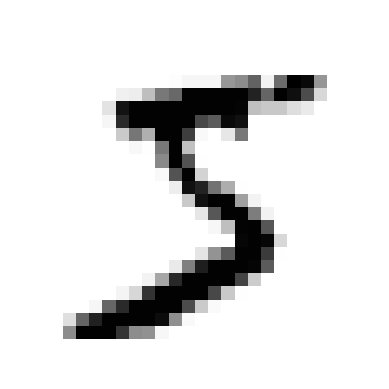

In [ ]:
# Select the first row of the scaled feature array
first_row = image_featured_scale.iloc[0]

# Reshape it to 28x28
reshaped_digit = first_row.values.reshape(28, 28)

# Display the digit using plt.imshow()
plt.imshow(reshaped_digit, cmap='Greys')

# Turn off the axes
plt.axis('off')

# Show the digit
plt.show()

## 4.F - Cross Validation for Logistic Regression

Create an instance of `LogisticRegression`, setting `solver='saga'` and `tol=0.1`. Use `cross_value_score()` to estimate the model's out-of-sample performance on the dataset. Use 10-fold CV with accuracy as the metric. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

Note that this could take a few minutes to run.

In [ ]:
image_lr = LogisticRegression(solver='saga', tol=0.1)

image_score = cross_val_score(image_lr, image_featured_scale, image_label, scoring='accuracy', cv=10, n_jobs=-1)

print(f"Scores: {image_score.round(3)}")
print(f"Mean Score: {image_score.mean().round(3)}")

Scores: [0.929 0.917 0.918 0.926 0.917 0.918 0.916 0.922 0.926 0.935]
Mean Score: 0.922


## 4.G - Cross Validation for KNN

Create an instance of `KNeighborsClassifier`, setting `n_neighbors=5`. Use `cross_value_score()` to estimate the model's out-of-sample performance on the dataset. Use 10-fold CV with accuracy as the metric. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

Experiment with the value of `n_neighbors` until you find a model with a CV score of **at least 0.97**.

Note that this could take a few minutes to run.

In [ ]:
image_neighbor = KNeighborsClassifier(n_neighbors=45)

image_score = cross_val_score(image_lr, image_featured_scale, image_label, scoring='accuracy', cv=10, n_jobs=-1)

print(f"Scores: {image_score.round(3)}")
print(f"Mean Score: {image_score.mean().round(3)}")

Scores: [0.928 0.918 0.919 0.926 0.917 0.918 0.916 0.922 0.925 0.935]
Mean Score: 0.922


## 4.H - Classification Report

Identify which of the two models gave you the best results. Then use that model with `cross_val_predict()` with `cv=10` to generate out-of-sample predictions for the dataset. Use these predictions with `classification_report()` to generate a classification report.

Note that this could take a few minutes to run.

In [ ]:
image_predict = cross_val_predict(image_lr, image_featured_scale, image_label, cv=10, n_jobs=-1) #

image_class = classification_report(image_label,image_predict)

print(image_class)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      6903
           1       0.95      0.97      0.96      7877
           2       0.92      0.90      0.91      6990
           3       0.91      0.89      0.90      7141
           4       0.93      0.93      0.93      6824
           5       0.89      0.87      0.88      6313
           6       0.94      0.96      0.95      6876
           7       0.93      0.93      0.93      7293
           8       0.89      0.88      0.89      6825
           9       0.89      0.91      0.90      6958

    accuracy                           0.92     70000
   macro avg       0.92      0.92      0.92     70000
weighted avg       0.92      0.92      0.92     70000



## 4.I - Confusion Matrix

Use your out-of-sample predictions with `confusion_matrix()` to generate a confusion matrix. Display the confusion matrix as a DataFrame, with the rows and columns labeled according to the actual class names.

In [ ]:
image_confusion = confusion_matrix(image_label,image_predict)

label = np.unique(image_label)

image_confusion_df = pd.DataFrame(image_confusion, index=label, columns=label)

image_confusion_df

,0,1,2,3,4,5,6,7,8,9
0,6672,1,24,18,14,63,51,10,44,6
1,1,7665,38,22,6,34,8,19,72,12
2,35,71,6298,100,79,36,84,88,162,37
3,25,30,159,6378,5,237,25,72,134,76
4,17,31,41,8,6349,4,71,24,46,233
5,70,28,57,216,67,5511,114,30,160,60
6,42,20,51,2,56,91,6569,8,33,4
7,23,30,89,29,67,13,4,6797,18,223
8,40,133,67,169,36,187,60,28,6013,92
9,34,39,17,82,182,44,3,198,61,6298


## 4.J - Displaying New Digits

The csv file `data/new_digits.csv` contains pixel values for 3 new digits. Load this data into a DataFrame. Then display these digits in a 1x3 grid of subplots using `plt.imshow()` with `cmap='Greys'`. As before, turn off the axes for each subplot.

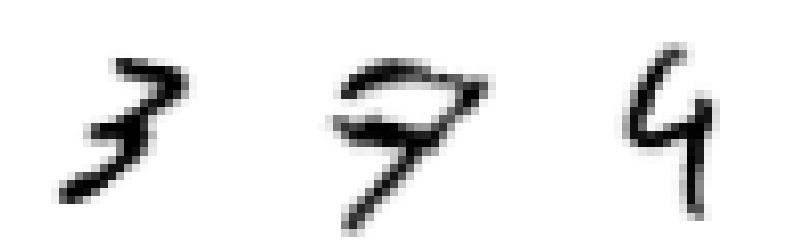

In [ ]:
new_digits = pd.read_csv('data/new_digits.csv')

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Display each digit in a subplot
for i in range(3):
    # Select the row corresponding to the digit
    digit_row = new_digits.iloc[i]

    # Reshape the digit to 28x28
    reshaped_digit = digit_row.values.reshape(28, 28)

    # Plot the digit in the current subplot
    axes[i].imshow(reshaped_digit, cmap='Greys')

    # Turn off the axes for each subplot
    axes[i].axis('off')

# Show the subplots
plt.show()

## 4.K - Applying the Model

Create a new array containing scaled values for the new digits. Then fit your best-performing model to the training data and use the `predict_proba()` method to generate probability predictions for the new observations. Print the resulting probability array.

In [ ]:
image_lr.fit(image_featured_scale, image_label)

# new_digits

new_digits_new_feature_scaled = new_digits / 255

new_digits_new_feature_scaled

new_digits_pred = image_lr.predict(new_digits_new_feature_scaled)
print(new_digits_pred,'\n')

new_digits_prob = image_lr.predict_proba(new_digits_new_feature_scaled)
print(new_digits_prob.round(3))

[2 9 4] 

[[0.    0.13  0.418 0.128 0.002 0.001 0.    0.012 0.12  0.188]
 [0.002 0.    0.003 0.    0.016 0.147 0.    0.013 0.147 0.672]
 [0.    0.    0.001 0.001 0.672 0.006 0.003 0.    0.023 0.293]]


# Submission Instructions

1. Perform a Restart and Run All by clicking **Tools > Restart session and run all**.
2. Copy the link to your notebook by clicking **Share > Copy Link**.
3. Paste the copied link into the `notebook_url` field in the [Notebook Renderer](https://colab.research.google.com/drive/1CJTipys46ldZxJFwnt7XbdjQUfkmoXeU?usp=sharing) tool and then execute the cell to render the notebook.
4. The Notebook Renderer will open up a save file dialog. Save the resulting HTML file yo your local machine.
5. Submit the HTML file to Canvas.